# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from setup import *

# Regional boundaries

## Download data
Note that the TIGER/LINE boundaries and ACS data of the subdivisions of Indiana at different scales were already downloaded in [../../spr_4608/code/1_Geometry_ACS.ipynb](../../spr_4608/code/1_Geometry_ACS.ipynb), but they were for the year 2020 (I think). The files were then directly copied from `$MK/spr_4608/data/geometry` to `$MK/spr_4711/data/acs`.

However, since the UMN access data used the 2010 definitions, they are downloaded explicitly from the Census website.

In [3]:
!mkdir -p ../data/boundary

### Blocks

### Block groups

### Traffic analysis zones

### Tracts

### Counties

### CBSAs

## Combine scales

In [4]:
%%time
# t=22s
bound = pd.concat([
    gpd.read_file(P.data / f'boundary/{scale}.geojson')
    .assign(scale=scale).astype({'geoid': str})
    for scale in tqdm(['bg','tract','county'])
]).disp()
bound.to_file(P.data / f'export/boundaries.geojson')

  0%|          | 0/3 [00:00<?, ?it/s]

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: epsg:4326


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
0,181379685003,Block Group 3,2566010,39626,"POLYGON ((-85.20815 39.304011, -85.208134 39.3...",bg


CPU times: user 17.8 s, sys: 210 ms, total: 18 s
Wall time: 18.2 s


In [5]:
bound = gpd.read_file(P.data / 'export/boundaries.geojson').disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: epsg:4326


,geoid,name,aland,awater,scale,geometry
,<object>,<object>,<int64>,<int64>,<object>,<geometry>
0,181379685003,Block Group 3,2566010,39626,bg,"POLYGON ((-85.20815 39.304011, -85.208134 39.3..."


# ACS data

## Download data (not working)
For 2010 to suit the AAA calculations

In [6]:
def download_acs_shp(scale, year=2012, state=18, root=U.mkdir(P.data / 'geometry'),
                     fields=mk.acs.IMP_FIELDS):
    assert scale in ['county', 'tract', 'bg', 'city']
    # download the shapefile
    # shp = (mk.geo.get_tiger_shp(scale, f'{root}/{scale}.shp.zip', fips=18)
    #        .rename(columns=str.lower).to_crs(mk.geo.CRS_DEG)
    #        [['geoid','namelsad','aland','awater','geometry']])
    # download the ACS data
    geo = {'state': f'{state:02}'} | dict(
        county={'county': '*'},
        tract={'county': '*', 'tract': '*'},
        bg={'county': '*', 'tract': '*', 'block group': '*'}
    )[scale]
    acs = mk.acs.download(list(geo.items()), list(fields.keys()), year=year)
    return acs
           # .rename(columns=fields).reorder_levels(list(geo.keys())))
    acs.index = acs.index.map(''.join).rename('geoid')
    acs = acs[acs['popu'] > 0]
    # join the tables
    name = 'name ' if 'name' in shp.columns else ''
    shp = (shp[f'geoid {name}namelsad aland awater geometry'.split()]
           .merge(acs, on='geoid').astype({'geoid': int}))
    return shp
    shp.to_file(f'{root}/{scale}.gpkg')
    
# %time df = download_acs_shp('bg'); df

## Rebase geoids
Find the mapping between the latest ACS data's geoids and the 2010 geoids used in the AAA data.

In [7]:
def map_old_to_new_geoids(scale):
    bound_old = gpd.read_file(P.data / f'boundary/{scale}.geojson')
    acs_new = gpd.read_file(P.data / f'ACS/{scale}.gpkg')
    ixn = acs_new.overlay(bound_old, how='intersection', keep_geom_type=False)
    ixn['area'] = ixn.to_crs(CRS_M).area
    map_ = (ixn.sort_values('area').groupby('geoid_1').last()
            ['geoid_2'].rename('old').rename_axis('new').reset_index())
    return map_

In [8]:
%time new2old = {scale: map_old_to_new_geoids(scale) for scale in ['bg', 'tract', 'county']} # t=28s

CPU times: user 26.5 s, sys: 463 ms, total: 26.9 s
Wall time: 27.1 s


In [9]:
new2old['bg'].head(3)

,new,old
0,180010301001,180010301001
1,180010301002,180010301002
2,180010301003,180010301003


In [10]:
def get_acs_old(scale, maps=new2old):
    acs = gpd.read_file(P.data / f'ACS/{scale}.gpkg')
    acs = (acs.drop(columns=['namelsad','aland','awater','geometry',
                             'age_median','inc_avg','inc_median'])
           .rename(columns={'geoid': 'new'})
           .merge(maps[scale], on='new', how='left').drop(columns='new')
           .rename(columns={'old': 'geoid'}).astype({'geoid': str})
           .groupby('geoid').sum(numeric_only=True))
    return acs
    
# %time x = get_acs_old('bg'); x

In [11]:
acs = []
for scale in ['bg','tract','county']:
    df = get_acs_old(scale)
    df.insert(0, 'scale', scale)
    acs.append(df.reset_index())
acs = pd.concat(acs).reset_index(drop=True).disp()

6,314 rows x 31 cols; Memory: 2.2 MiB


,geoid,scale,popu,hh,age_minor,age_adult,age_senior,sex_female,sex_male,race_white,race_black,edu_eligible,edu_bachelors,employ_total,employ_in_LF,employ_not_in_LF,inc_total,inc_total_hh,hh_poor,hh_nonpoor,cm_car,cm_pool,cm_pt,cm_bus,cm_subway,cm_taxi,cm_bike,cm_walk,cm_wfm,pop_poor,pop_nonpoor
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,180010301001,bg,1349.0,413.0,402.0,663.0,213.0,700.0,649.0,1345.0,0.0,769.0,111.0,556.0,566.0,383.0,32611900.0,31643000.0,47.0,366.0,410.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,NaN,NaN


In [ ]:
{
    'Total'
}

In [12]:
acs.to_csv(P.data / 'export/acs.csv', index=False)

In [45]:
acs = gpd.read_file(P.data / 'ACS/bg.gpkg').disp()

5,272 rows x 37 cols; Memory: 2.0 MiB; CRS: epsg:4326


,geoid,namelsad,aland,awater,popu,hh,age_minor,age_adult,age_senior,age_median,sex_female,sex_male,race_white,race_black,edu_eligible,edu_bachelors,employ_total,employ_in_LF,employ_not_in_LF,inc_total,inc_avg,inc_total_hh,inc_median,pop_poor,pop_nonpoor,hh_poor,hh_nonpoor,cm_car,cm_pool,cm_pt,cm_bus,cm_subway,cm_taxi,cm_bike,cm_walk,cm_wfm,geometry
,<int64>,<object>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<geometry>
0,181290406002,Block Group 2,1336298,18390,754.0,302.0,105.0,342.0,276.0,53.7,423.0,331.0,728.0,4.0,618.0,193.0,356.0,378.0,248.0,32933800.0,43679.0,32293400.0,105455.0,None,None,17.0,285.0,282.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,305.0,"POLYGON ((-87.925882 37.934615, -87.925867 37...."


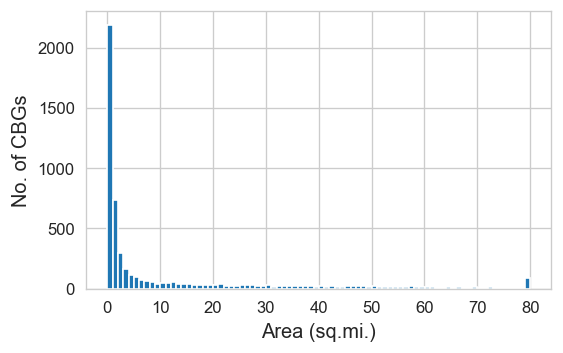

In [6]:
ax = U.plot(size=(5, 3), ylab='No. of CBGs', xlab='Area (sq.mi.)', dpi=120)
(acs.to_crs(CRS_M).area * U.SQM2SQMI).clip(0, 80).hist(ax=ax, bins=80);

In [7]:
fancy_ses_cols = {
    'popu': 'Population',
    'hh': 'No. of Households',
    'pop_density': 'Popu Density (/sq.mi.)',
    'pct_senior': '% Popu Aged >64',
    'pct_non_white': '% Popu of Minority Race',
    'pct_no_degree': '% Popu without College Degree',
    'pct_bpl': '% Popu Below Poverty Line',
}

In [8]:
def get_ses_vars(acs, cols=fancy_ses_cols):
    df = acs.set_index(['geoid', 'namelsad']).pipe(lambda df: df[df['popu'] > 0])
    # population density
    df['area'] = df.to_crs(CRS_M).area * U.SQM2SQMI
    df['pop_density'] = df['popu'] / df['area']
    # % seniors (aged >64 y)
    df['pct_senior'] = 100 * df['age_senior'] / (
        df['age_minor'] + df['age_adult'] + df['age_senior'])
    # % non-Whites
    df['pct_non_white'] = 100 * df['race_white'] / df['popu']
    # % population without college degree
    df['pct_no_degree'] = 100 * (1 - df['edu_bachelors'] / df['edu_eligible'])
    # % population below poverty line
    df['pct_bpl'] = 100 * df['pop_poor'] / (df['pop_poor'] + df['pop_nonpoor'])
    # % population unemployed
    df['pct_unemploy'] = 100 * df['employ_not_in_LF'] / (
        df['employ_in_LF'] + df['employ_not_in_LF'])
    return df[list(cols.keys()) + ['geometry']].rename(columns=cols).reset_index()
    
# get_ses_vars(acs)

In [9]:
def save_ses_vars(scale, cols=fancy_ses_cols):
    acs = gpd.read_file(P.data / f'acs/{scale}.gpkg')
    ses = get_ses_vars(acs, cols)
    ses.to_file(P.data / f'acs/ses_{scale}.geojson')

# LEHD-LODES

## Download data

In [10]:
def download_lehd_lodes(dataset='od', job_type='JT00', state='in', part='main',
                        segment='S000', year=2019, lodes_version=7,
                        aggregate_bg=False, save=True):
    assert lodes_version in [6, 7]
    assert dataset in ['od', 'rac', 'wac']
    assert part in ['main', 'aux']
    assert job_type in [f'JT{i:02}' for i in range(6)]
    assert segment in 'S000 SA01 SA02 SA03 SE01 SE02 SE03 SI01 SI02 SI03'.split()
    root = f'https://lehd.ces.census.gov/data/lodes'
    fname = {'od': f'{state}_od_{part}_{job_type}_{year}',
            'rac': f'{state}_rac_{segment}_{job_type}_{year}',
            'wac': f'{state}_wac_{segment}_{job_type}_{year}'}[dataset]
    url = f'{root}/LODES{lodes_version}/{state}/{dataset}/{fname}.csv.gz'
    df = pd.read_csv(url).drop(columns='createdate', errors='ignore')
    idx_cols = {'od': ['h_geocode', 'w_geocode'],
                'rac': ['h_geocode'], 'wac': ['w_geocode']}[dataset]
    df = df.astype({col: str for col in idx_cols})
    if aggregate_bg:
        for col in idx_cols:
            df[col] = df[col].str.slice(0, 12)
        df = df.groupby(idx_cols).sum().reset_index()
    if save:
        fpath = U.mkdir(P.data / f'lehd_lodes/{dataset}') / f'{fname}.csv'
        df.to_csv(fpath, index=False)
    return df

In [11]:
rac = pd.read_csv(glob(str(P.data) + '/lehd_lodes/rac/*')[0]).disp()

4,811 rows x 42 cols; Memory: 1.5 MiB


,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,180010301001,493,114,233,146,101,164,228,5,0,4,17,130,24,56,15,5,16,3,14,3,17,34,91,4,26,13,16,489,1,0,1,0,2,475,18,44,133,117,85,264,229


In [12]:
wac = pd.read_csv(glob(str(P.data) + '/lehd_lodes/wac/*')[0]).disp()

4,783 rows x 52 cols; Memory: 1.9 MiB


,w_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,180010301001,102,17,40,45,15,48,39,1,0,0,26,62,0,0,6,0,0,0,4,0,0,0,0,0,0,3,0,99,2,1,0,0,0,96,6,11,36,28,10,76,26,0,0,0,0,0,0,0,0,0,0


In [13]:
od = pd.read_csv(glob(str(P.data) + '/lehd_lodes/od/*')[0]).disp()

1,036,602 rows x 12 cols; Memory: 94.9 MiB


,h_geocode,w_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,180010301001,180010301001,5,0,1,4,1,4,0,3,1,1


In [14]:
geom = pd.read_csv(P.data / 'lehd_lodes/in_xwalk.csv.gz').disp()

/tmp/ipykernel_266193/3682522803.py:1: DtypeWarning: Columns (28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  geom = pd.read_csv(P.data / 'lehd_lodes/in_xwalk.csv.gz').disp()


267,071 rows x 43 cols; Memory: 330.3 MiB


,tabblk2010,st,stusps,stname,cty,ctyname,trct,trctname,bgrp,bgrpname,cbsa,cbsaname,zcta,zctaname,stplc,stplcname,ctycsub,ctycsubname,stcd116,stcd116name,stsldl,stsldlname,stsldu,stslduname,stschool,stschoolname,stsecon,stseconname,trib,tribname,tsub,tsubname,stanrc,stanrcname,necta,nectaname,mil,milname,stwib,stwibname,blklatdd,blklondd,createdate
,<int64>,<int64>,<object>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<float64>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<object>,<int64>,<float64>,<object>,<object>,<int64>,<float64>,<int64>,<float64>,<int64>,<float64>,<float64>,<object>,<int64>,<object>,<float64>,<float64>,<int64>
0,180010301001049,18,IN,Indiana,18001,"Adams County, IN",18001030100,"301 (Adams, IN)",180010301001,"1 (Tract 301, Adams, IN)",19540,"Decatur, IN",46733,46733.0,9999999,NaN,1800161884,"Preble township (Adams, IN)",1803,IN-03,18079,"State House District 79, IN",18019,"State Senate District 19, IN",1807680,"North Adams Community Schools, IN",9999999,NaN,99999,NaN,9999999,NaN,9999999,NaN,99999,NaN,NaN,NaN,18180003,Economic Growth Region 3,40.867454,-85.0133,20211018


# OSM

## Download from Geofabrik

## Clean database
- Convert layers to standard geographical CRS (EPSG 4326)
- Extract info about each layer's geometry type and 
- Export as .gpkg files

In [3]:
osm_layers = sorted(['natural','landuse','pofw','pois','railways','trafic',
                     'transport','water','waterways','buildings','roads'])

In [4]:
def clean_layers(layers=osm_layers, inpath=P.data / 'osm/raw',
                 outpath=P.data / 'osm'):
    layers = tqdm(layers)
    get_path = lambda x: inpath / f'gis_osm_{x}_free_1.shp'
    for layer in layers:
        layers.set_description(layer)
        df = []
        if get_path(layer).exists():
            df.append(gpd.read_file(get_path(layer)))
        if get_path(layer + '_a').exists():
            df.append(gpd.read_file(get_path(layer + '_a')))
        df = pd.concat(df).to_crs(CRS_DEG).rename(columns=str.lower)
        info = {'geometry': df.geometry.geom_type.value_counts().to_dict()}
        if 'fclass' in df.columns:
            info['fclass'] = df['fclass'].value_counts().sort_index().to_dict()
        if 'type' in df.columns:
            info['fclass'] = df['type'].value_counts().sort_index().to_dict()
        P.params.set({'data': {'osm': {layer: info}}})
        df.to_file(U.mkdir(outpath) / f'{layer}.gpkg')
    
# %time clean_layers()  # t=6:37